In [1]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import pandas as pd
import pickle  # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# import tensorflow as tf
#
# from keras.layers import Dense, LSTM, Flatten, Dropout  # importing dense layer
# from keras.models import Sequential  # importing Sequential layer

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader


In [12]:

feature = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
           "hot",
           "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
           "num_file_creations", "num_shells",
           "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count",
           "serror_rate", "srv_serror_rate",
           "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
           "dst_host_srv_count",
           "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
           "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
           "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"]

train = '../DATA/nslkdd/KDDTrain+.txt'
test = '../DATA/nslkdd/KDDTest+.txt'
test21 = '../DATA/nslkdd/KDDTest-21.txt'
train_data = pd.read_csv(train, names=feature)
test_data = pd.read_csv(test, names=feature)
test_data21 = pd.read_csv(test21, names=feature)
data = pd.concat([train_data, test_data], ignore_index=True)

data.drop(['difficulty'], axis=1, inplace=True)

# data.info()
#
# data.describe().T

data['label'].value_counts()


def change_label(df):
    df.label.replace(['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod',
                      'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm'], 'Dos', inplace=True)
    df.label.replace(['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail',
                      'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xlock', 'xsnoop'], 'R2L',
                     inplace=True)
    df.label.replace(['ipsweep', 'mscan', 'nmap', 'portsweep',
                      'saint', 'satan'], 'Probe', inplace=True)
    df.label.replace(['buffer_overflow', 'loadmodule', 'perl',
                      'ps', 'rootkit', 'sqlattack', 'xterm'], 'U2R', inplace=True)



change_label(data)

data.label.value_counts()




label
normal    77054
Dos       53387
Probe     14077
R2L        3880
U2R         119
Name: count, dtype: int64

In [13]:

label = pd.DataFrame(data.label)

std_scaler = StandardScaler()


def standardization(df, col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = std_scaler.fit_transform(arr.reshape(len(arr), 1))
    return df


numeric_col = data.select_dtypes(include='number').columns
data = standardization(data, numeric_col)

le2 = preprocessing.LabelEncoder()
enc_label = label.apply(le2.fit_transform)
data['intrusion'] = enc_label
print(data.shape)

data.drop(labels=['label'], axis=1, inplace=True)
print(data.shape)

data = pd.get_dummies(
    data, columns=['protocol_type', 'service', 'flag'], prefix="", prefix_sep="")
print(data.shape)

y_data = data['intrusion']
X_data = data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:', X_data.shape, '\ny_train has shape:', y_data.shape)

y_data = LabelBinarizer().fit_transform(y_data)

X_data = np.array(X_data)
y_data = np.array(y_data)

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.20, random_state=42)
print(X_train.shape, '\n', X_test.shape)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

(148517, 43)
(148517, 42)
(148517, 123)
X_train has shape: (148517, 122) 
y_train has shape: (148517,)
(118813, 122) 
 (29704, 122)


In [3]:

# define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_length):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(hidden_dim * seq_length, 50)
        self.fc2 = nn.Linear(50, output_dim)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x, _ = self.lstm3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


# 定义模型超参数
input_dim = X_train.shape[2]  # 输入特征数量
hidden_dim = 64  # LSTM 隐藏层单元数量
output_dim = 5  # 输出类别数量
seq_length = 1  # 序列长度
# 初始化模型
model = LSTMModel(input_dim, hidden_dim, output_dim, seq_length)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 等效于 categorical_crossentropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 输出模型结构
print(model)

# 查看模型参数总数
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")


LSTMModel(
  (lstm1): LSTM(122, 64, num_layers=2, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(64, 64, num_layers=2, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (lstm3): LSTM(64, 64, num_layers=2, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=5, bias=True)
)
Total trainable parameters: 218033


In [ ]:

# training the model on training dataset
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')  # 对于回归任务
y_train = np.argmax(y_train, axis=1)  # 转换为类别索引
y_test = np.argmax(y_test, axis=1)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # 输入
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # 分类标签 (CrossEntropyLoss 不需要 one-hot 编码)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 创建数据加载器
batch_size = 5000
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_train_tensor, y_train_tensor)  # 可拆分 train/val
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 定义训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    model.to(device)
    history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            # print(f"outputs.shape: {outputs.shape}, outputs.dtype: {outputs.dtype}")
            # print(f"y_batch.shape: {y_batch.shape}, y_batch.dtype: {y_batch.dtype}")
            # y_batch = torch.argmax(y_batch, dim=1)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss /= len(train_loader)
        train_accuracy = correct / total  # 计算训练集准确率
        history["loss"].append(train_loss)
        history["accuracy"].append(train_accuracy)

        # 验证
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_val).sum().item()
                total += y_val.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        print(
            f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {train_loss:.4f} - "
            f"Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}"
        )

    return history





In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 定义评估函数
def evaluate_model(model, test_loader, criterion):
    model.to(device)
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            loss = criterion(outputs, y_test)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_test).sum().item()
            total += y_test.size(0)

            # 收集所有真实标签和预测标签
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = correct / total
    print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy * 100:.2f}%")

    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    
    # 显示混淆矩阵
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(all_labels, all_preds, digits=4))

    return test_loss, test_accuracy




In [5]:

# 训练模型
epochs = 100
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)



Epoch [1/100] - Train Loss: 1.5186 - Val Loss: 1.3721 - Val Accuracy: 0.5185
Epoch [2/100] - Train Loss: 1.1459 - Val Loss: 0.9789 - Val Accuracy: 0.5185
Epoch [3/100] - Train Loss: 0.8793 - Val Loss: 0.8031 - Val Accuracy: 0.5185
Epoch [4/100] - Train Loss: 0.7386 - Val Loss: 0.6546 - Val Accuracy: 0.8326
Epoch [5/100] - Train Loss: 0.5593 - Val Loss: 0.4610 - Val Accuracy: 0.8496
Epoch [6/100] - Train Loss: 0.3953 - Val Loss: 0.3251 - Val Accuracy: 0.8589
Epoch [7/100] - Train Loss: 0.3007 - Val Loss: 0.2712 - Val Accuracy: 0.8608
Epoch [8/100] - Train Loss: 0.2536 - Val Loss: 0.2243 - Val Accuracy: 0.9488
Epoch [9/100] - Train Loss: 0.2034 - Val Loss: 0.1717 - Val Accuracy: 0.9519
Epoch [10/100] - Train Loss: 0.1622 - Val Loss: 0.1493 - Val Accuracy: 0.9553
Epoch [11/100] - Train Loss: 0.1468 - Val Loss: 0.1382 - Val Accuracy: 0.9595
Epoch [12/100] - Train Loss: 0.1375 - Val Loss: 0.1316 - Val Accuracy: 0.9612
Epoch [13/100] - Train Loss: 0.1316 - Val Loss: 0.1265 - Val Accuracy: 0.

Test Loss: 0.0337 - Test Accuracy: 99.01%


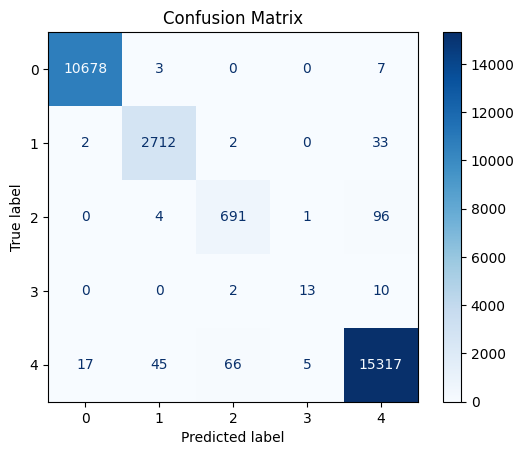

              precision    recall  f1-score   support

           0     0.9982    0.9991    0.9986     10688
           1     0.9812    0.9865    0.9839      2749
           2     0.9080    0.8725    0.8899       792
           3     0.6842    0.5200    0.5909        25
           4     0.9906    0.9914    0.9910     15450

    accuracy                         0.9901     29704
   macro avg     0.9124    0.8739    0.8909     29704
weighted avg     0.9900    0.9901    0.9900     29704



In [11]:

# 评估模型
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

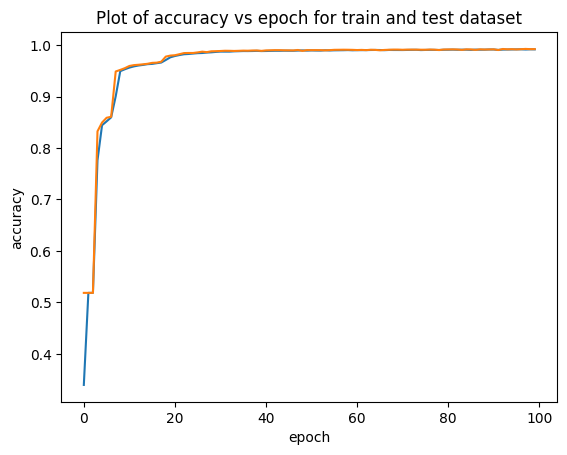

In [6]:

# Plot of accuracy vs epoch for train and test dataset
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.savefig('lstm_accuracy.png')
# plt.clf()  # 清空当前图像
plt.show()



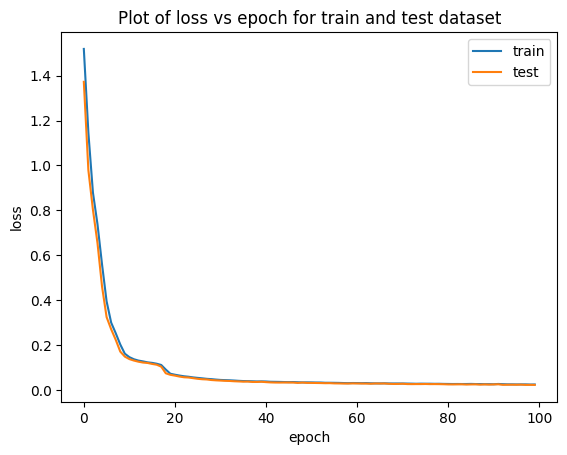

In [7]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
# plt.savefig('lstm_loss.png')
plt.show()

# 计算混淆矩阵